#Flood Prediction

Import Required Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
ENABLE_OUTPUT = True

## Telemetri Data

In [3]:
def gsheet_to_csv(url: str):
  sheet_url = url
  csv = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
  return csv

df_telemetri_rainfall = pd.read_csv(gsheet_to_csv("https://docs.google.com/spreadsheets/d/1nI8m27noE1mMiXQXde8jyXD6-qhuMQ2tE-gXxBkuxi4/edit#gid=0"))
if ENABLE_OUTPUT: df_telemetri_rainfall

In [4]:
df_telemetri_waterlevel = pd.read_csv(gsheet_to_csv("https://docs.google.com/spreadsheets/d/1xy16th0oBqQ9kux8XGKmkk6AO1flGq1hj1kYqDLn4YI/edit#gid=0"))
df_telemetri_waterlevel.rename(columns = {'Water Level (cm)': 'water_level', 'Date ':'Date'}, inplace = True)
if ENABLE_OUTPUT: df_telemetri_waterlevel

In [5]:
# Pandas Left Join is Out of Memory
# pd.merge(df_telemetri_rainfall, df_telemetri_waterlevel, how="left", on="Location")
# Let's try to use sql

**Pandas Left Join is Out of Memory**
```python
pd.merge(df_telemetri_rainfall, df_telemetri_waterlevel, how="left", on="Location")
```
Let's try to use sql instead

In [6]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [7]:
# Save to sql
df_telemetri_waterlevel.to_sql("telemetri_waterlevel", if_exists="replace", con=engine)
df_telemetri_rainfall.to_sql("telemetri_rainfall", if_exists="replace", con=engine)

In [8]:
# check length
if ENABLE_OUTPUT:
  print(len(df_telemetri_rainfall))
  print(len(df_telemetri_waterlevel))

182885
191553


Join operations ini untuk menggabungkan data dengan cara mengambil semua data yang memiliki nilai **water_level** dan **Rainfall** (jika ada label data banjir dari PUPR)
```
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time

UNION

SELECT 
  tw.Date AS Date,
  tw.Time AS Time,
  tw.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_waterlevel AS tw
LEFT JOIN telemetri_rainfall AS tr
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
```
Namun karena menggunakan asumsi bahwa jika **RainfallStatus** == lebat  sebagai label banjir maka digunakan join ini
```
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
```

In [9]:
query = engine.execute('''
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
''')
df_tmrain_tmwater = pd.DataFrame(query.fetchall())
df_tmrain_tmwater.columns = query.keys()
if ENABLE_OUTPUT: df_tmrain_tmwater

In [10]:
if ENABLE_OUTPUT: df_tmrain_tmwater.describe()

## Preprocessing Data

Number of Missing Value 

In [11]:
if ENABLE_OUTPUT: df_tmrain_tmwater.isnull().sum() 

In [12]:
if ENABLE_OUTPUT: df_tmrain_tmwater['RainfallStatus'].unique()

In [13]:
# Clean Column RainfallStatus
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Cerah\\', 'RainfallStatus'] = "Cerah"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Light', 'RainfallStatus'] = "Ringan"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Is', 'RainfallStatus'] = "Sedang"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Bright', 'RainfallStatus'] = "Cerah"
df_tmrain_tmwater = df_tmrain_tmwater[df_tmrain_tmwater['RainfallStatus'].notna()]
if ENABLE_OUTPUT: df_tmrain_tmwater['RainfallStatus'].unique()

### Data metrics defenition
* Rainfall (mm)

  1mm rainfall means every one square meter area is filled with the water of height 1mm.
  1 square meter = 1000mm length ×1000mm breath
  So 1mm rain means 1000mm length × 1000mm breath × 1mm height = 1litre of water.
  Every square meter has one litre of water

In [14]:
if ENABLE_OUTPUT: df_tmrain_tmwater[df_tmrain_tmwater['WaterLevel'].notna()][df_tmrain_tmwater['RainfallStatus'] == "Lebat"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [15]:
# Convert metrics to float

from re import compile as re_compile, sub as re_sub

re_rainfall_metric = re_compile(r'[^\d.]')
re_waterlevel_metric = re_compile(r'[^\d,]')

def rainfall_metric_to_float(metric):
  try:
    return float(re_rainfall_metric.sub('', metric))
  except Exception as err:
    return -1.0
def waterlevel_metric_to_float(metric):
  try:
    return float(re_sub(r',', '', re_waterlevel_metric.sub('', metric)))
  except Exception as err:
    return -1.0
ds_tmrain_tmwater_rainfall = df_tmrain_tmwater.apply(lambda row: rainfall_metric_to_float(str(row["Rainfall"])), axis=1)
ds_tmrain_tmwater_waterlevel = df_tmrain_tmwater.apply(lambda row: waterlevel_metric_to_float(str(row["WaterLevel"])), axis=1)

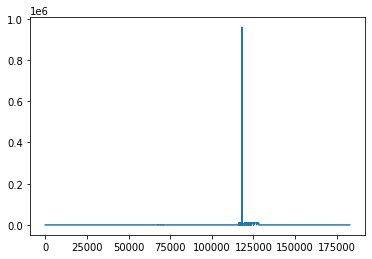

In [16]:
if ENABLE_OUTPUT: ds_tmrain_tmwater_waterlevel.plot()

In [17]:
water_level_value_replacement = ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel != -1].std()
if ENABLE_OUTPUT: water_level_value_replacement

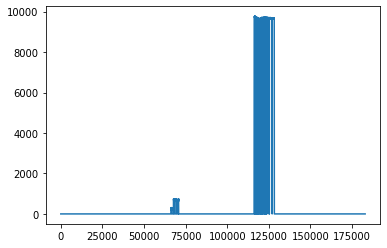

In [18]:
# There is high spikes (probably measurement error)
max_idx = ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel == ds_tmrain_tmwater_waterlevel.max()].index[0]
ds_tmrain_tmwater_waterlevel[max_idx] = water_level_value_replacement
if ENABLE_OUTPUT: ds_tmrain_tmwater_waterlevel.plot()

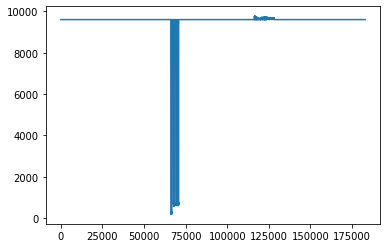

In [19]:
# Let's also replace missing value (-1) there
ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel == -1] = water_level_value_replacement
if ENABLE_OUTPUT: ds_tmrain_tmwater_waterlevel.plot()

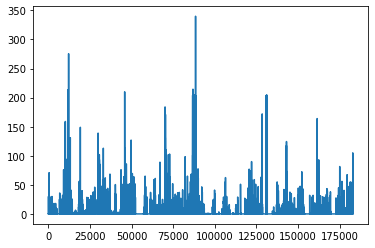

In [20]:
if ENABLE_OUTPUT: ds_tmrain_tmwater_rainfall.plot()

In [21]:
# Looks good, let's join to main df
df_tmrain_tmwater["WaterLevel"] = ds_tmrain_tmwater_waterlevel
df_tmrain_tmwater["Rainfall"] = ds_tmrain_tmwater_rainfall
if ENABLE_OUTPUT: df_tmrain_tmwater

In [22]:
from datetime import datetime
def convert_to_datetime(date: str):
  try:
    return datetime.strptime(date, '%d-%b-%y')
  except ValueError:
    return datetime.strptime(date, '%d-%B-%y')

df_tmrain_tmwater['Date'] = df_tmrain_tmwater.apply(lambda row: convert_to_datetime(row["Date"]), axis=1)
if ENABLE_OUTPUT: df_tmrain_tmwater

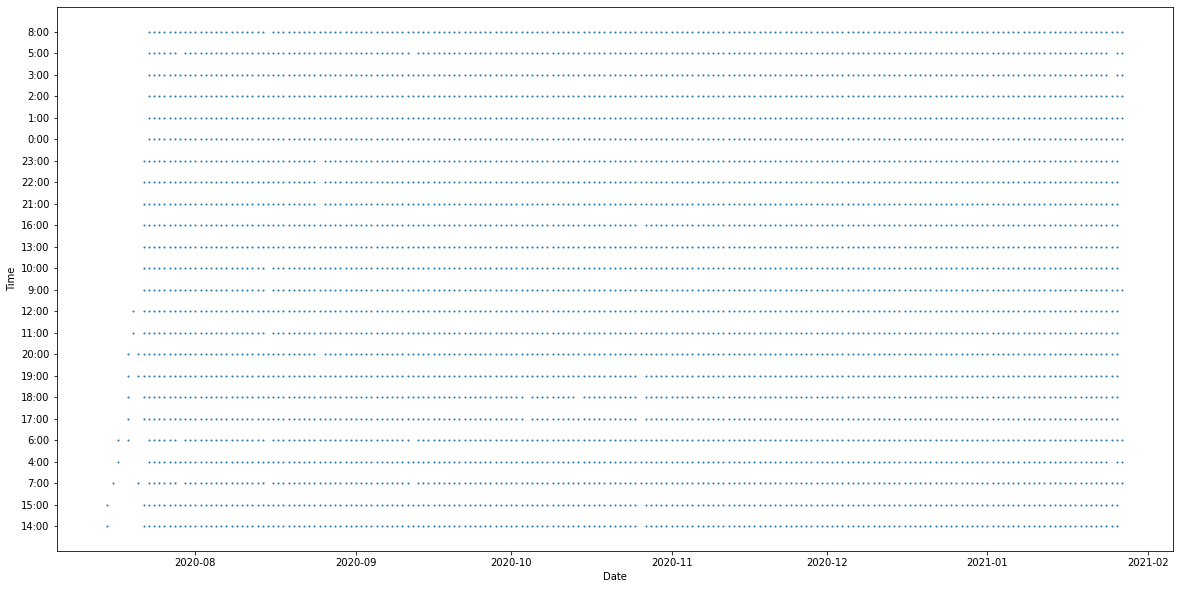

In [23]:
# See if time is regularly updated

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

if ENABLE_OUTPUT: df_tmrain_tmwater[df_tmrain_tmwater["Location"] == "Sumur Batu"].plot("Date", "Time", kind="scatter", s=1)

There are many missing values! (Not regular)

Let's just take by date and not by time

In [24]:
df_tmrain_tmwater_days = df_tmrain_tmwater.sort_values("Rainfall", ascending=False).groupby(["Location", "Date"]).head(1)
if ENABLE_OUTPUT: df_tmrain_tmwater_days

In [25]:
# Asumsi Labeling
df_tmrain_tmwater_days['Banjir'] = df_tmrain_tmwater_days.apply(lambda row: 1 if str(row['RainfallStatus']).lower() == "lebat" or str(row['RainfallStatus']).lower() == "sangat lebat" else 0, axis=1)
df_tmrain_tmwater_days.to_csv("df_tmrain_tmwater_days.csv", index=False)
if ENABLE_OUTPUT: df_tmrain_tmwater_days

In [26]:
# Berapa banjir ya
df_tmrain_tmwater_days["Banjir"].sum()

976

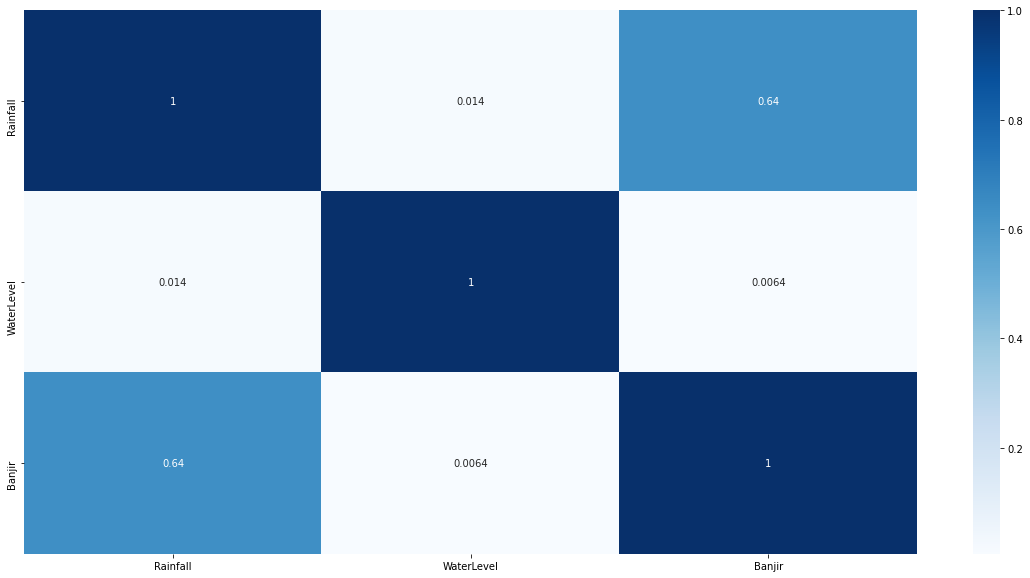

In [27]:
# Bagaimana korelasi WaterLevel, Rainfall, dan Banjir?
import seaborn as sb
if ENABLE_OUTPUT: sb.heatmap(df_tmrain_tmwater_days[["Rainfall", "WaterLevel", "Banjir"]].corr(), cmap="Blues", annot=True)

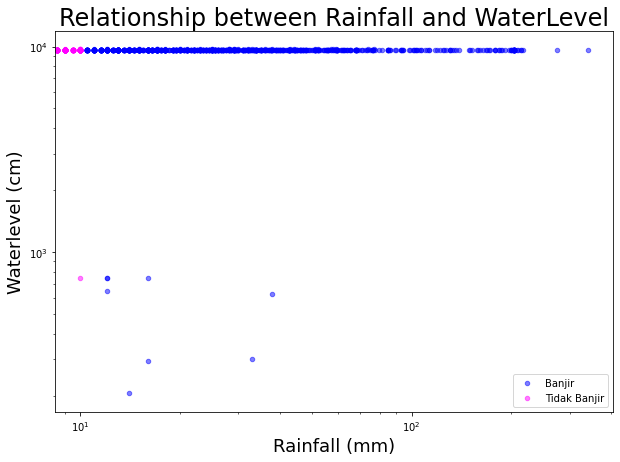

In [28]:
if ENABLE_OUTPUT: 
  ax1 = df_tmrain_tmwater_days[df_tmrain_tmwater_days['Banjir'] == 1].plot(kind='scatter', x='Rainfall', y='WaterLevel', color='blue', alpha=0.5, figsize=(10, 7), logx=True, logy=True)
  df_tmrain_tmwater_days[df_tmrain_tmwater_days['Banjir'] == 0].plot(kind='scatter', x='Rainfall', y='WaterLevel', color='magenta', alpha=0.5, figsize=(10 ,7), ax=ax1, logx=True, logy=True)
  plt.legend(labels=['Banjir', 'Tidak Banjir'])
  plt.title('Relationship between Rainfall and WaterLevel', size=24)
  plt.xlabel('Rainfall (mm)', size=18)
  plt.ylabel('Waterlevel (cm)', size=18);

Tidak terlalu bagus untuk WaterLevel vs Banjir (Mungkin karena data tidak lengkap)


Karena tidak bagus korelasinya, maka digunakan satu kolom saja yakni 

X[Rainfall]

Y[Banjir]



## Create Model

### Models for detecting banjir(1) or tidak banjir(0)

In [29]:
import pickle
import json

class Transformer:
  """Convert non numeric categorical data to numeric value
  """
  def __init__(self):
    self.mapping_keys = {}
    self.mapping_location = "transformer-map.json"

  def load(self):
    self.mapping_keys = json.load(open(self.mapping_location, "r"))
    return self.mapping_location

  def fit_transform(self, df):
    columns = df.columns.values
    self.mapping_keys = {}

    for column in columns:
      text_digit_vals = {}
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        column_contents = df[column].values.tolist()
        unique_elements = sorted(set(column_contents), key=lambda x: str(x))
        x = 0
        for unique in unique_elements:
          if unique not in text_digit_vals:
            text_digit_vals[unique] = x
            x += 1
        df[column] = df.apply(lambda row: text_digit_vals[row[column]], axis=1)
        self.mapping_keys[column] = text_digit_vals

      return df

  def transform(self, df):
    columns = df.columns.values
    for column in columns:
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        df[column] = df.apply(lambda row: self.mapping_keys[column][row[column]], axis=1)
    return df
  
  def save_mapping(self):
    json.dump(self.mapping_keys, open(self.mapping_location, "w"))
    return self.mapping_location

In [30]:
# Convert categorical data to mapping numbers

transformer = Transformer()
df_banjir = transformer.fit_transform(df_tmrain_tmwater_days[["Location", "Rainfall", "Banjir"]])

# Save banjir mapping
banjir_mapping_location = transformer.save_mapping()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
# Training
import numpy as np
from sklearn import preprocessing, model_selection, neighbors # cross_validation has been deprecated so use model_selection instead
import pandas as pd
import os
if not os.path.exists('models'): os.makedirs('models') # model saving location



X = np.array(df_banjir.drop(['Banjir'], 1))
y = np.array(df_banjir['Banjir'])

# Normalization of Rainfall values
scaler = preprocessing.StandardScaler()
X[:, 1] = scaler.fit_transform(X[:, 1].reshape(-1,1)).ravel()
pickle.dump(scaler, open("scaler.pkl", "wb"))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2)

clf = neighbors.KNeighborsClassifier()

clf.fit(X_train, y_train)

# save classifier model
pickle.dump(clf, open("models/mknn-predict-banjir.pkl", "wb"))

accuracy = clf.score(X_test, y_test)
if ENABLE_OUTPUT: print('Accuracy=', accuracy)

Accuracy= 0.9969806763285024


In [32]:
# Predicting

def predict_banjir(input_value):
  df_banjir_to_predict = pd.DataFrame(input_value, columns=["Location", "Rainfall"])
  df_banjir_to_predict = transformer.transform(df_banjir_to_predict)

  # Normalize Rainfall
  df_banjir_to_predict["Rainfall"] = scaler.transform(df_banjir_to_predict["Rainfall"].values.reshape(-1, 1)).ravel()

  print('Input=',input_value)
  predictions = clf.predict(df_banjir_to_predict.values)
  print('Predictions', predictions)
  return predictions

if ENABLE_OUTPUT: predict_banjir([["Cawang", 213.5],["Kampung Kelapa", 0],["Cawang", 213.5]])

Input= [['Cawang', 213.5], ['Kampung Kelapa', 0], ['Cawang', 213.5]]
Predictions [1 0 1]


## Rainfall Forecasting Model

In [33]:
from sklearn.linear_model import LinearRegression
def get_rainfall_by_location(location, upto_date=None):
  if upto_date:
    return df_tmrain_tmwater_days[["Date", "Location", "Rainfall"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")[df_tmrain_tmwater_days["Date"] <= upto_date]
  return df_tmrain_tmwater_days[["Date", "Location", "Rainfall"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")

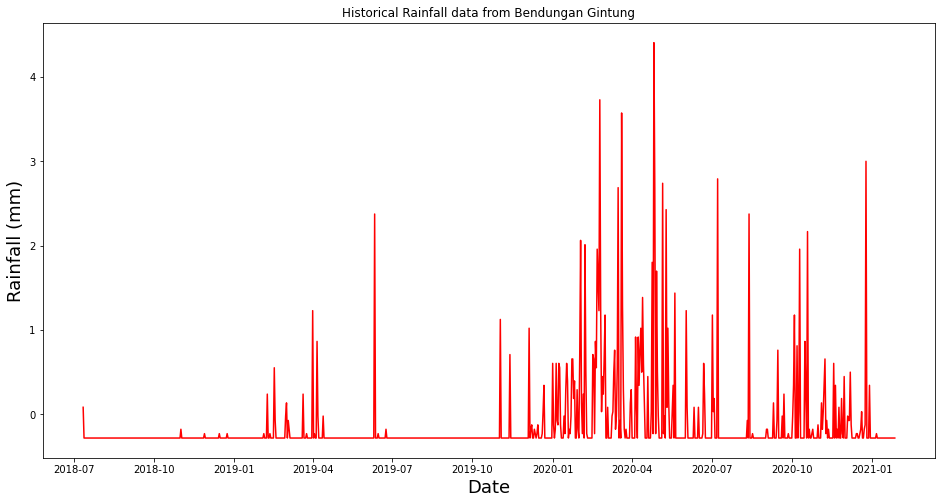

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


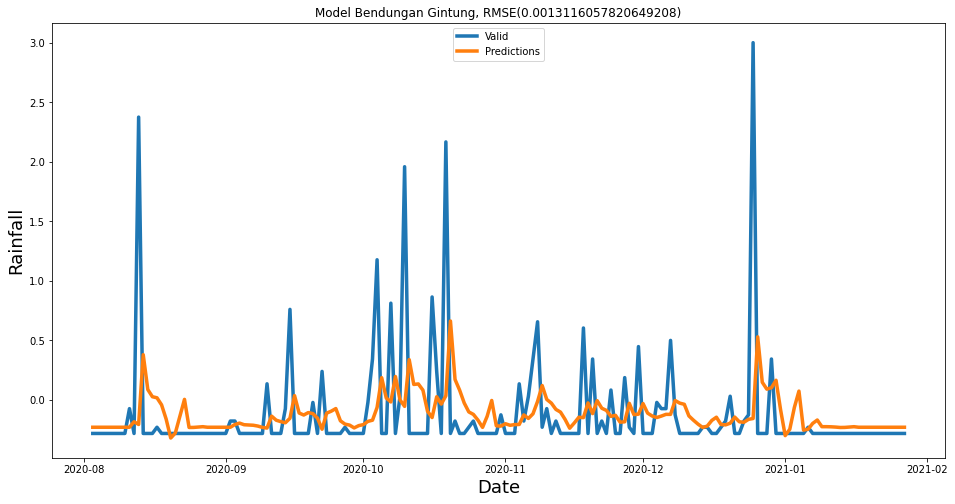

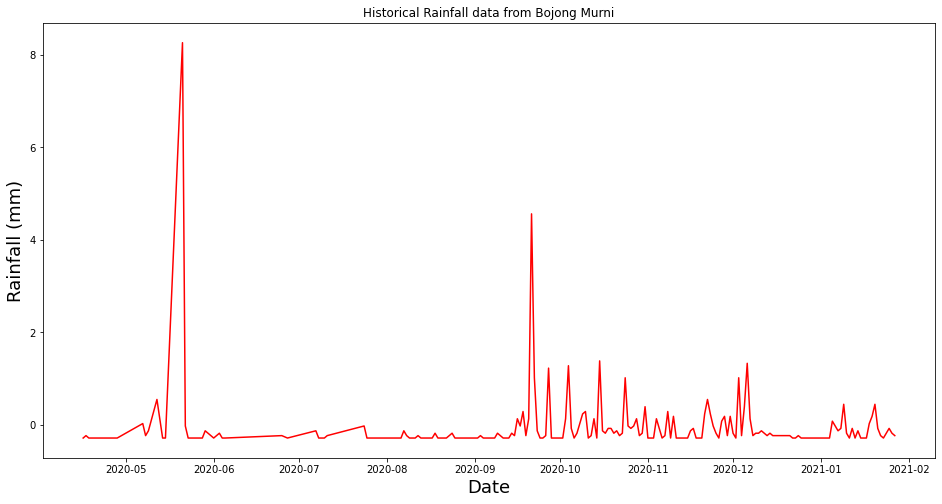

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


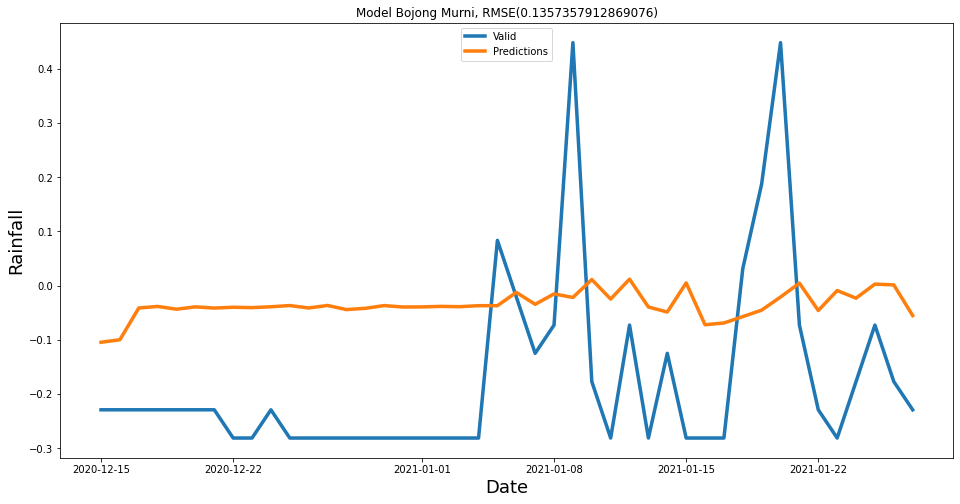

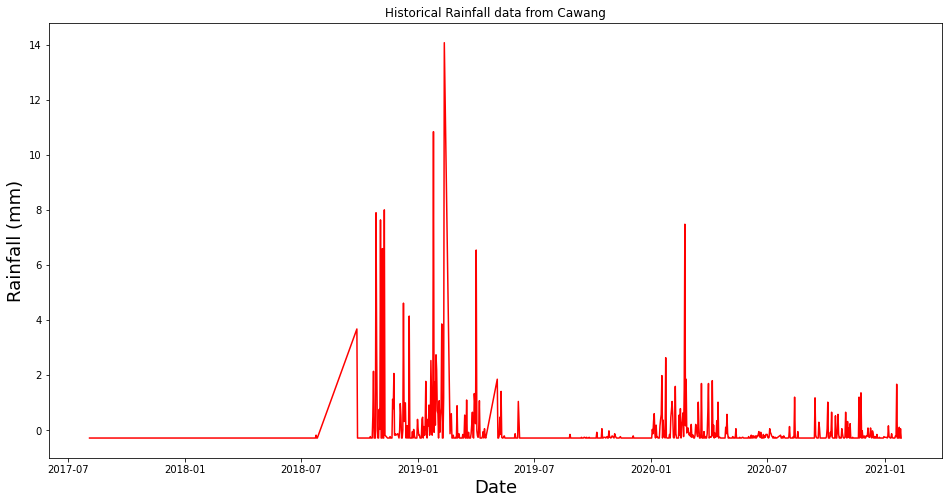

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


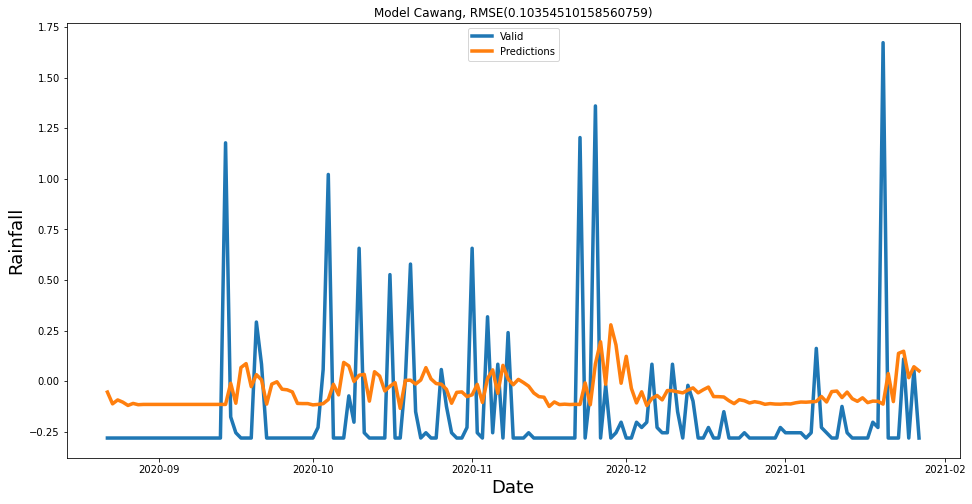

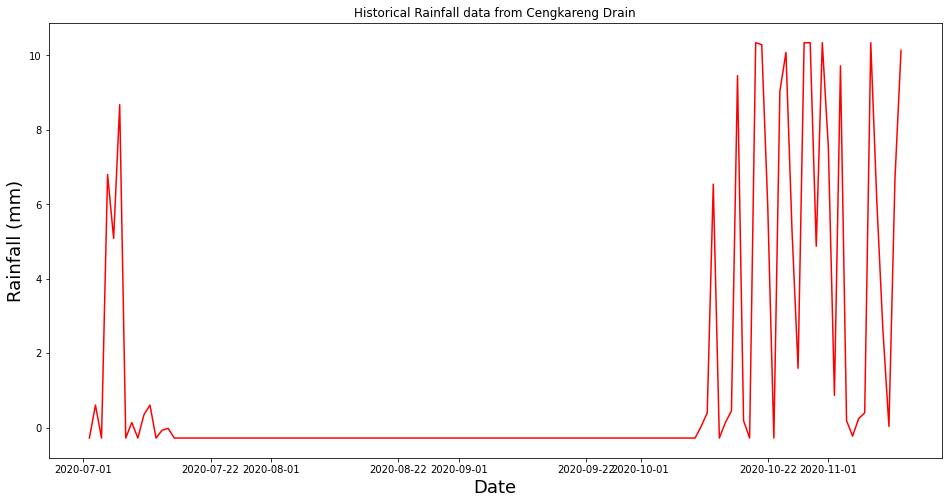

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


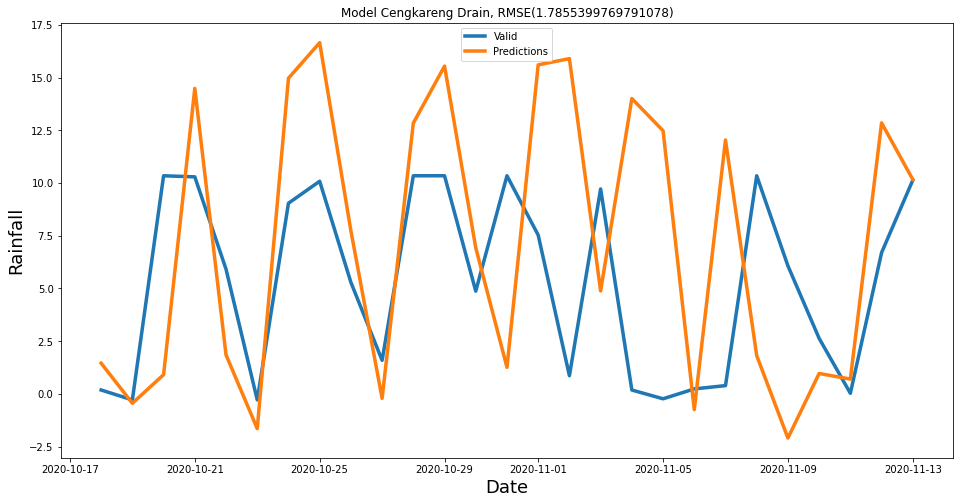

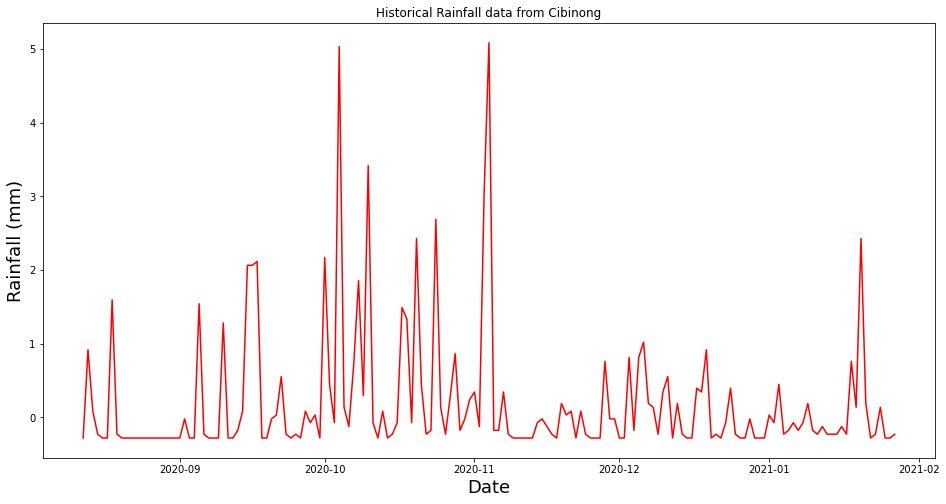

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


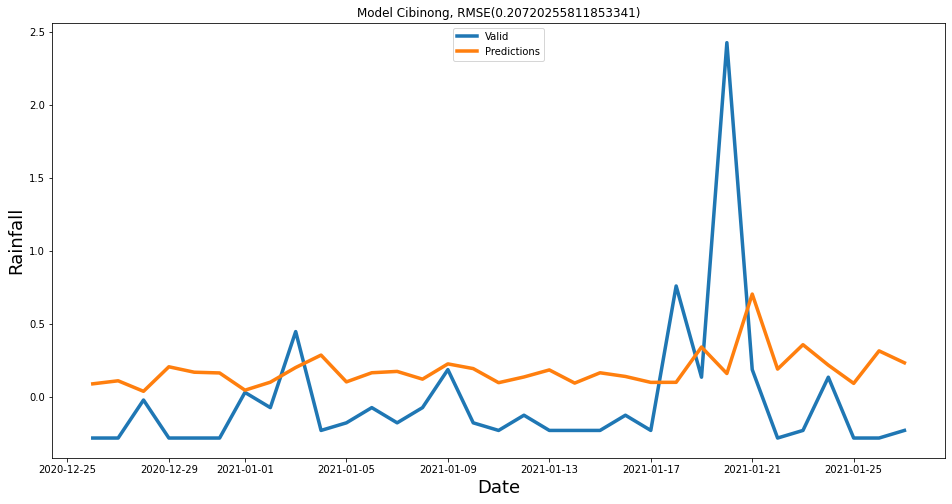

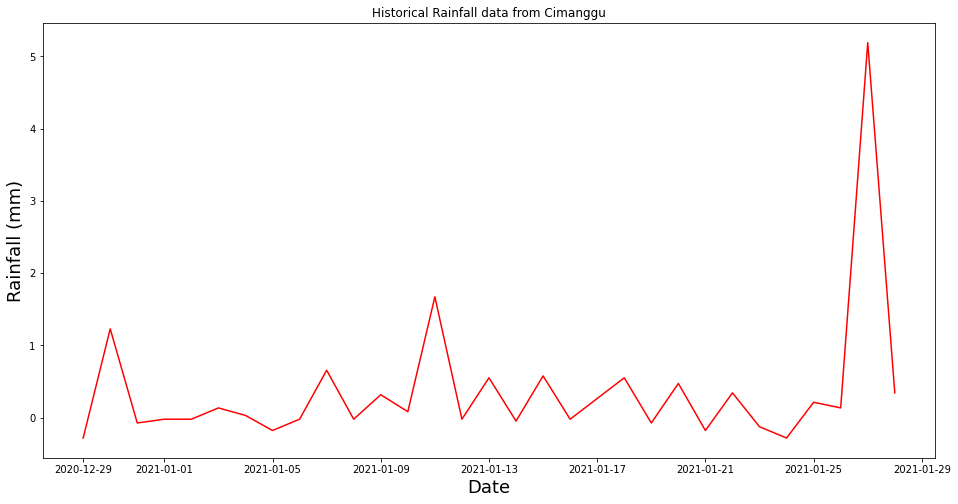

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


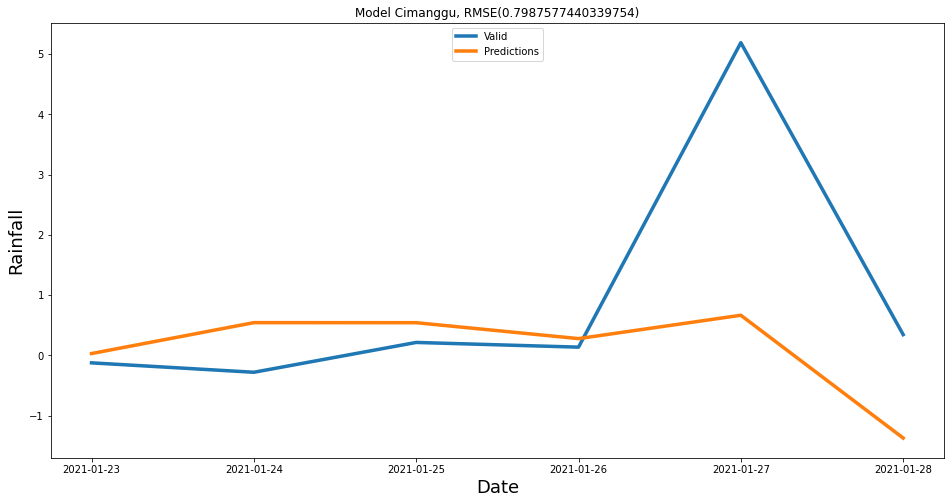

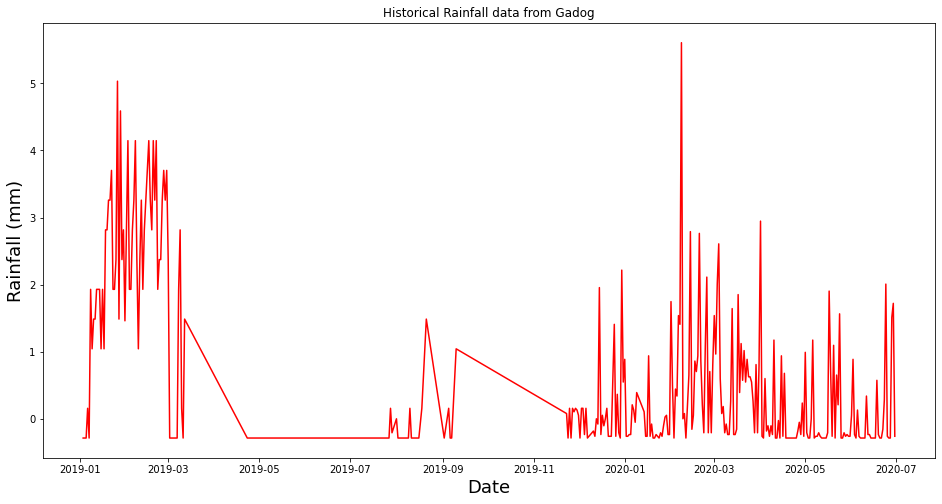

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


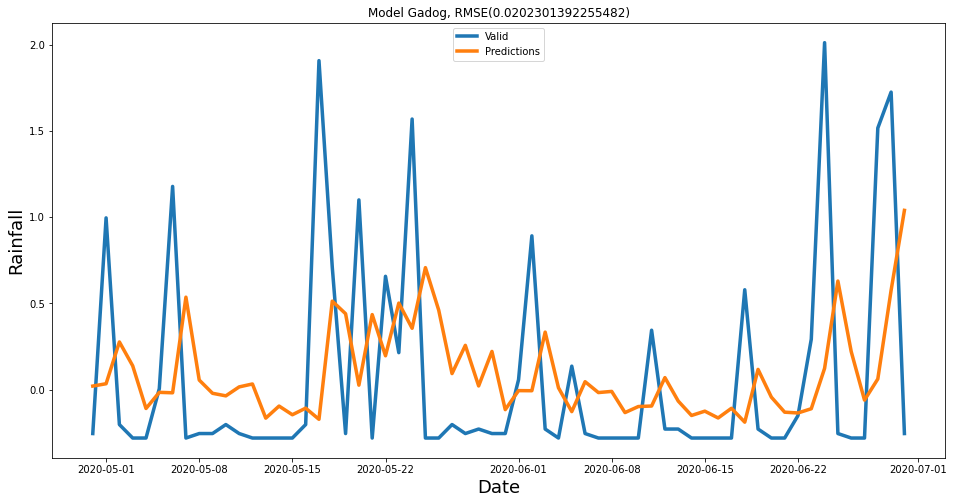

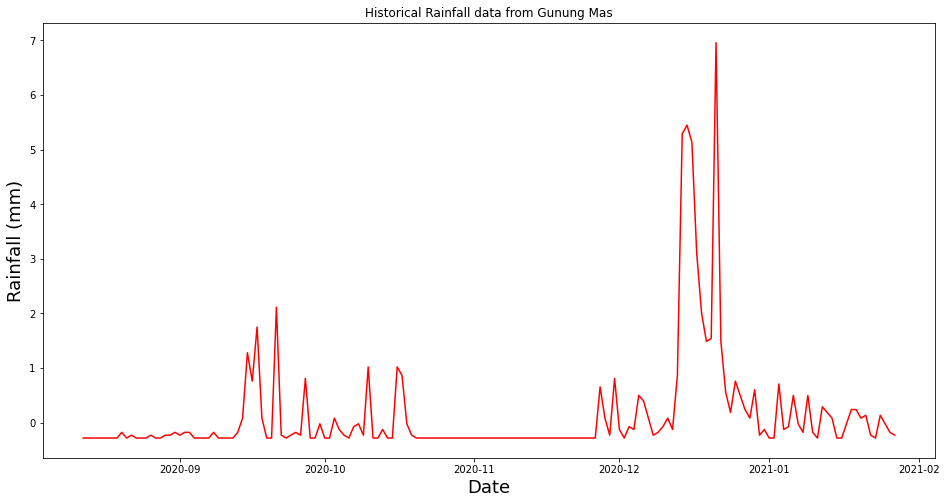

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


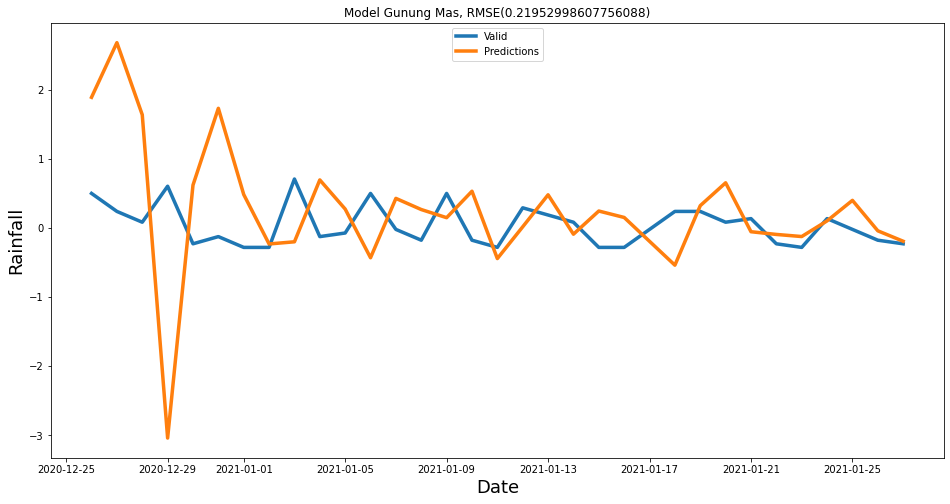

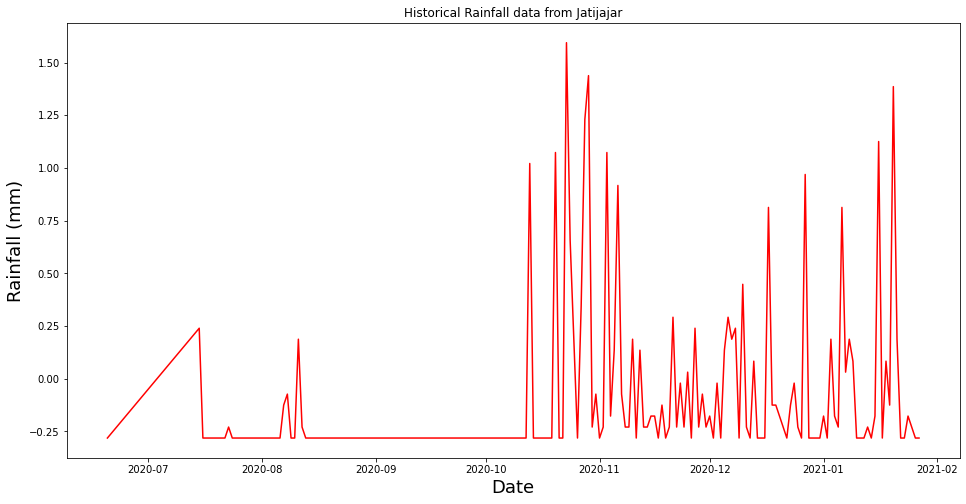

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


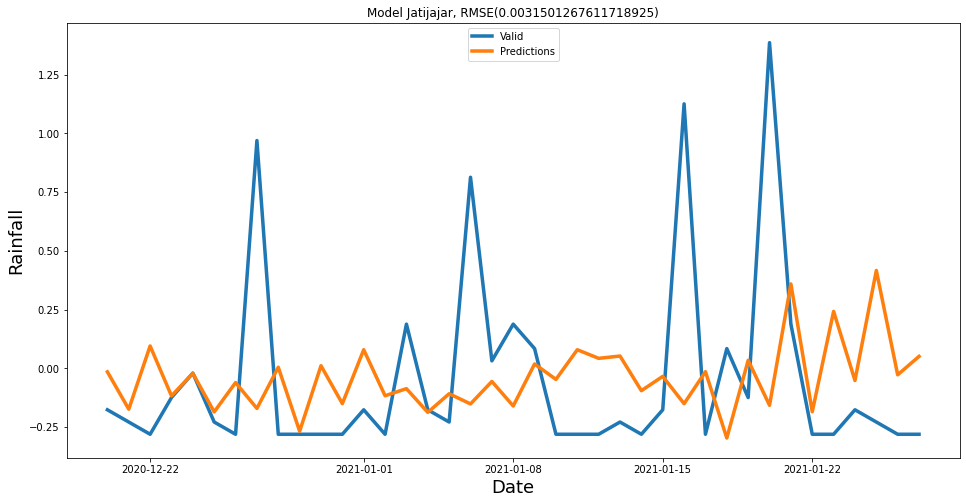

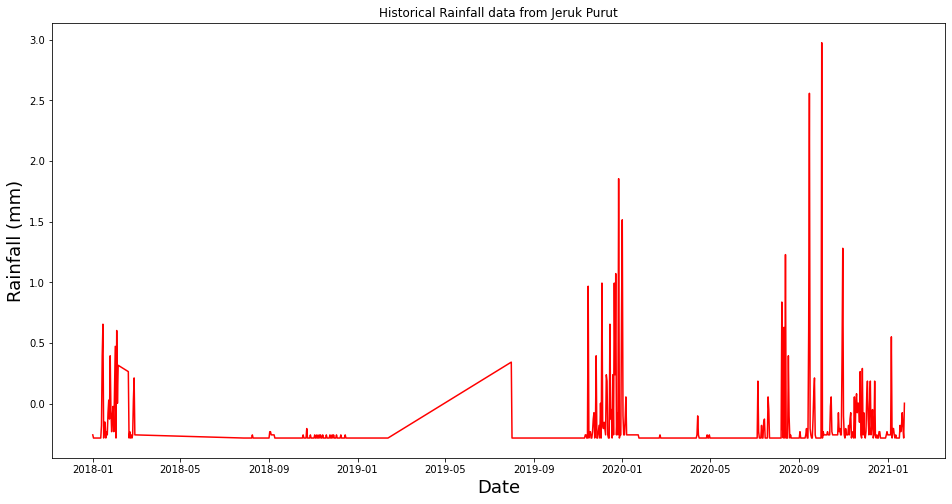

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


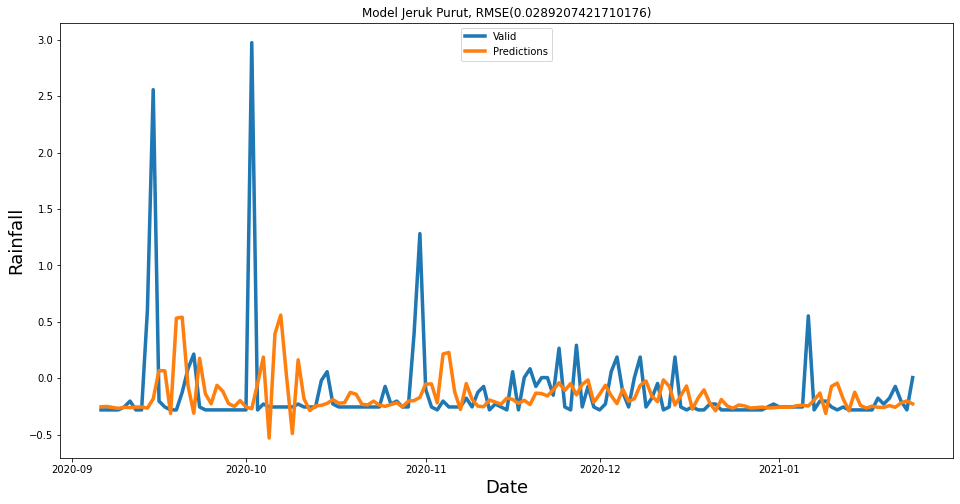

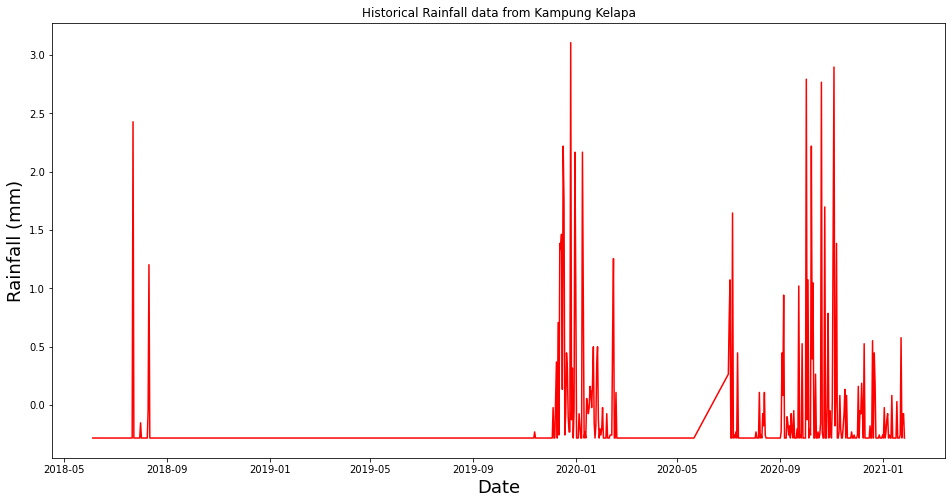

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


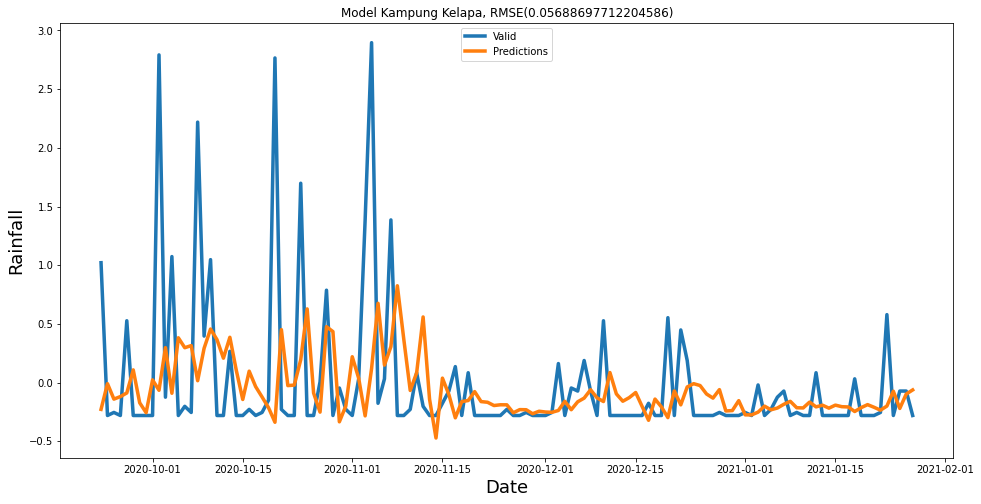

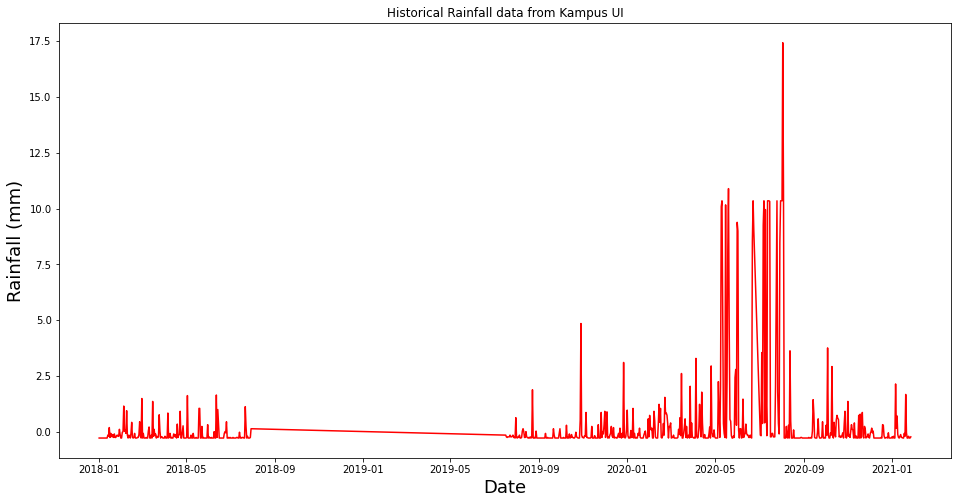

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


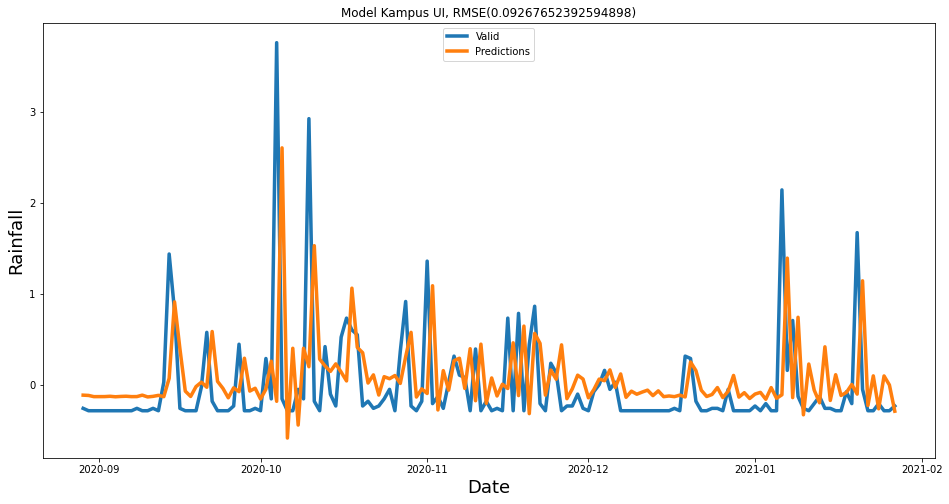

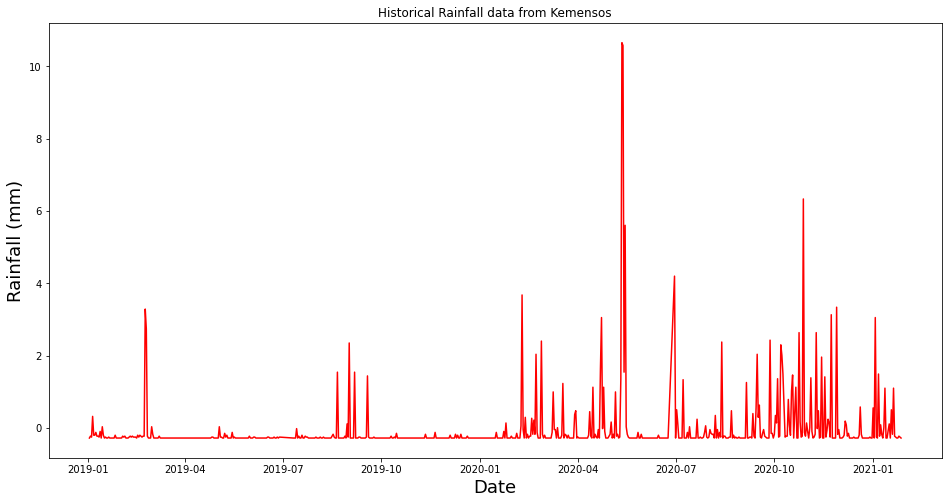

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


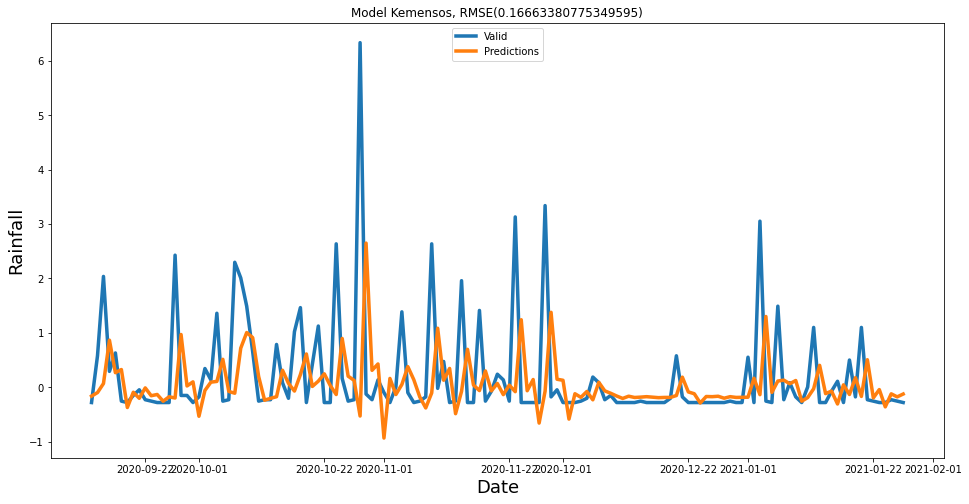

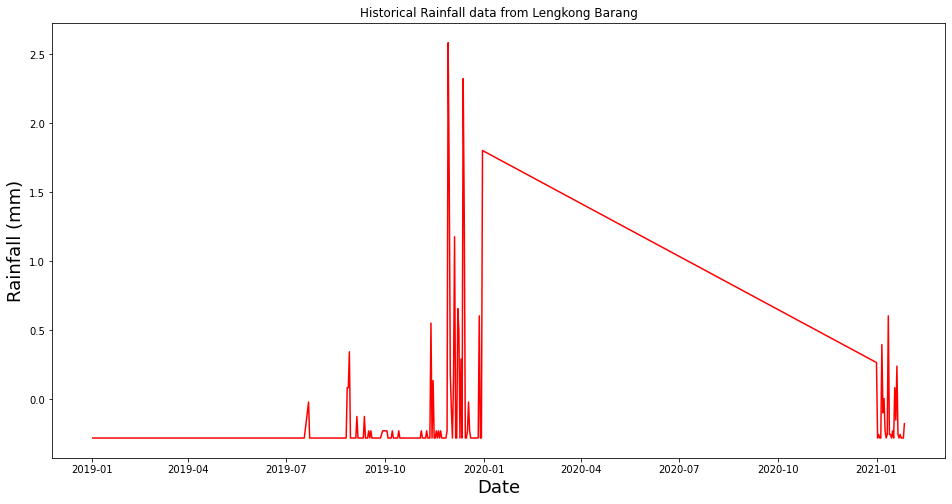

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


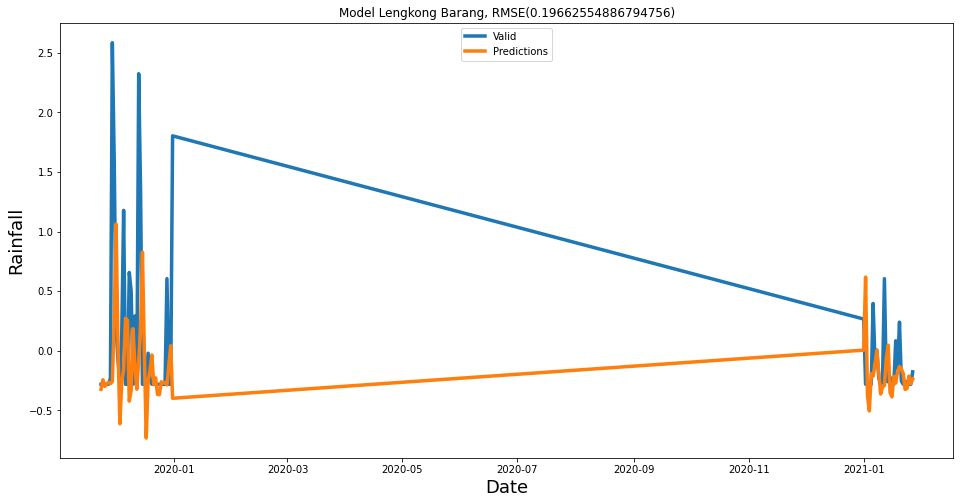

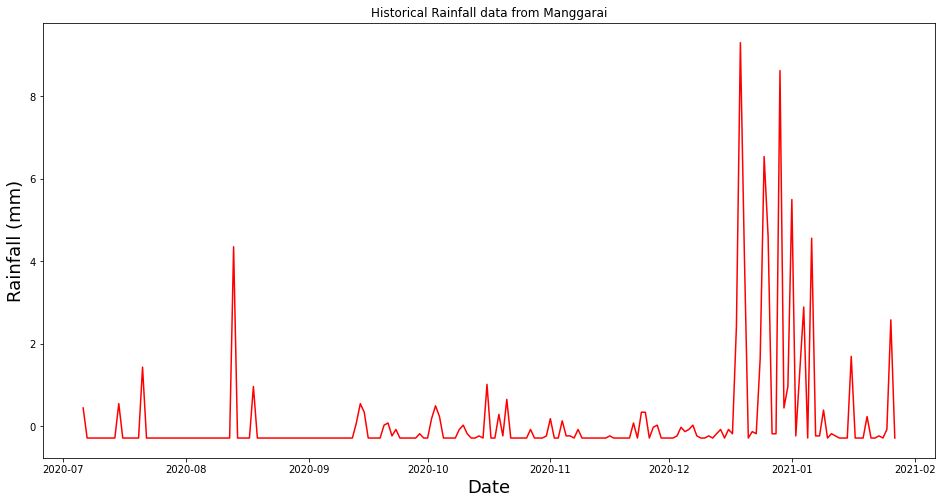

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


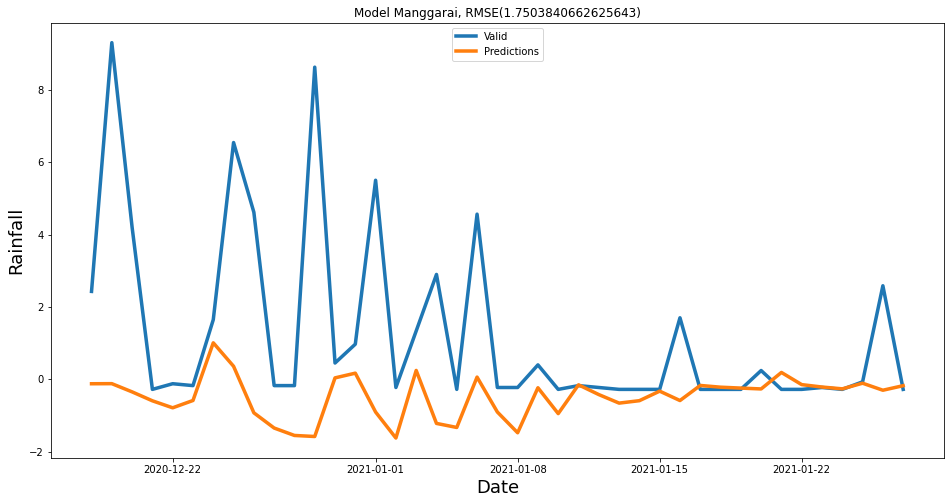

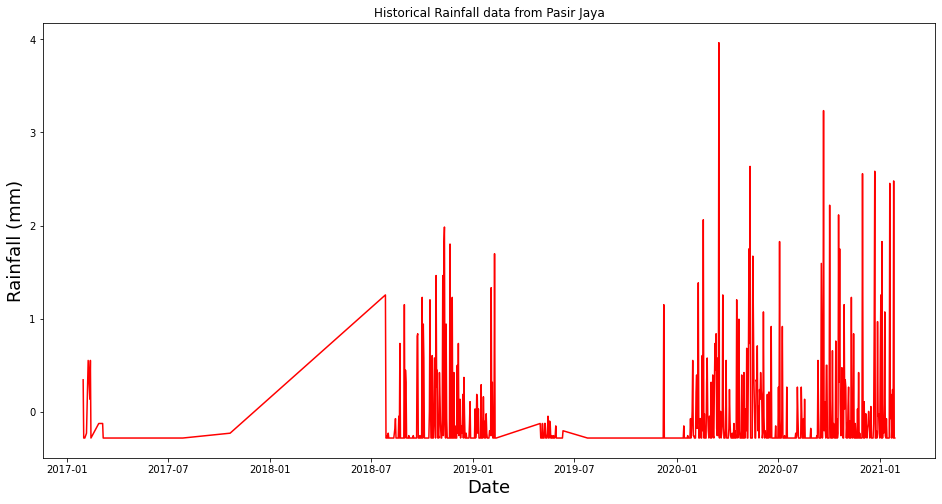

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


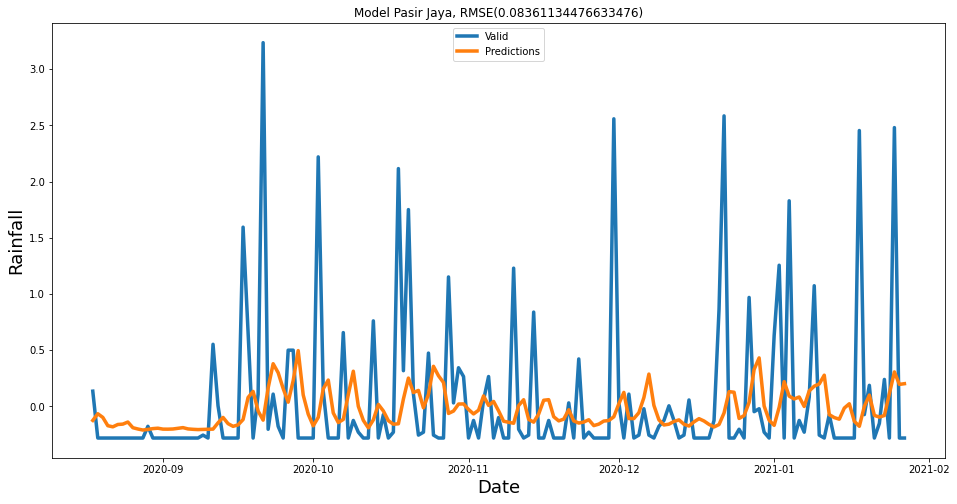

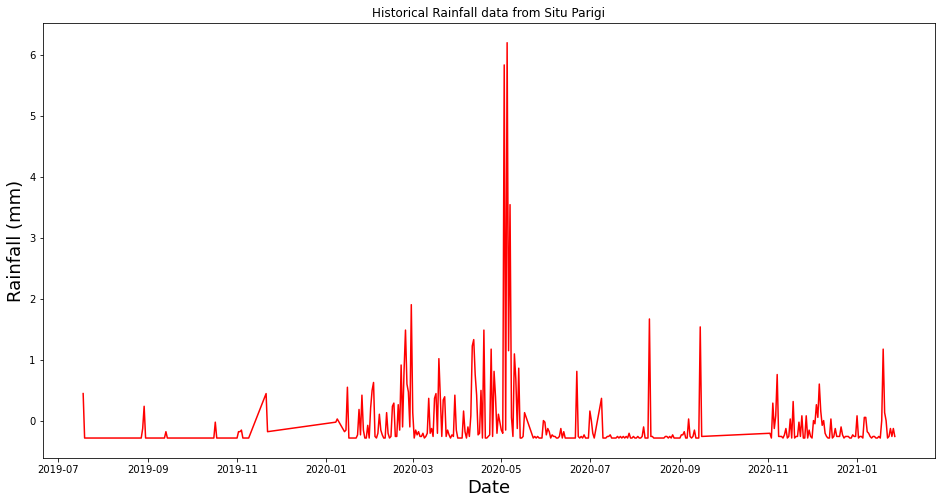

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


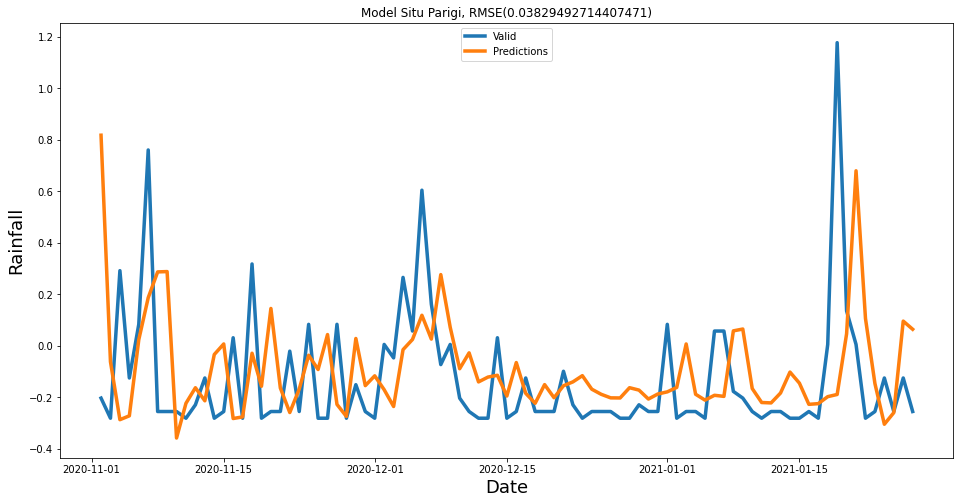

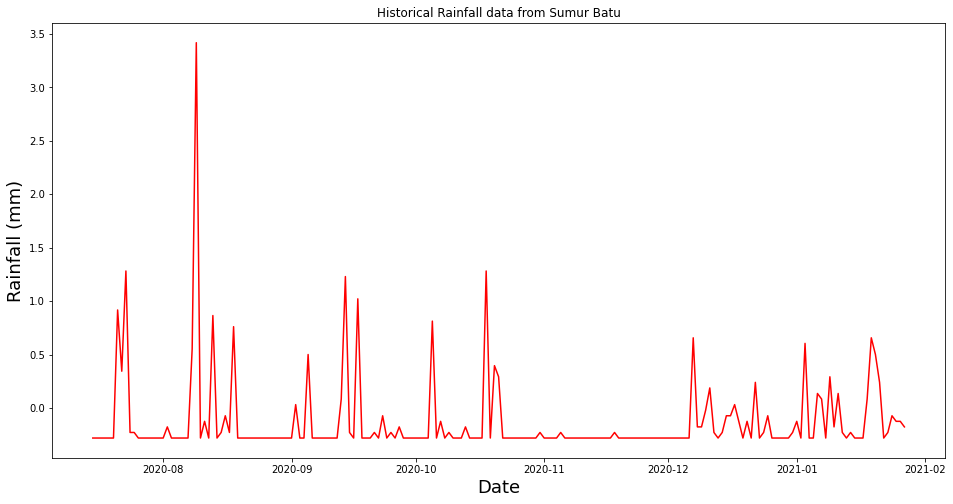

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


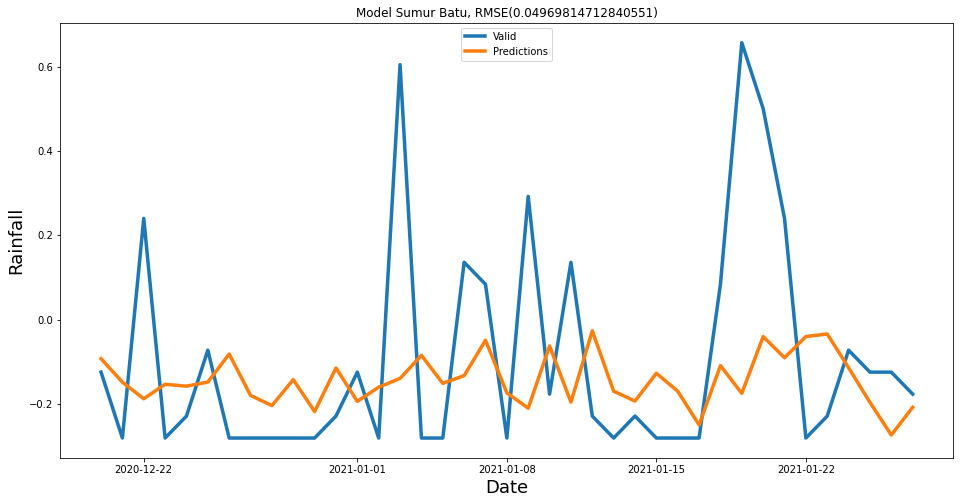

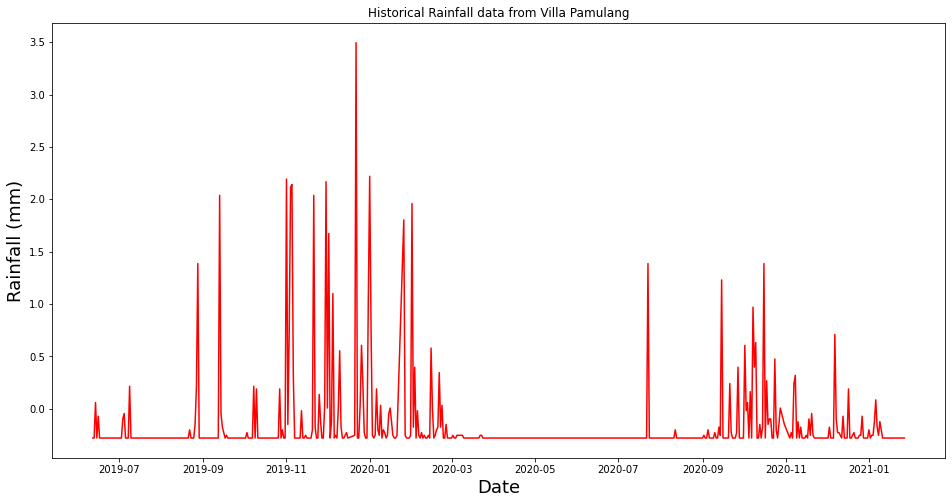

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


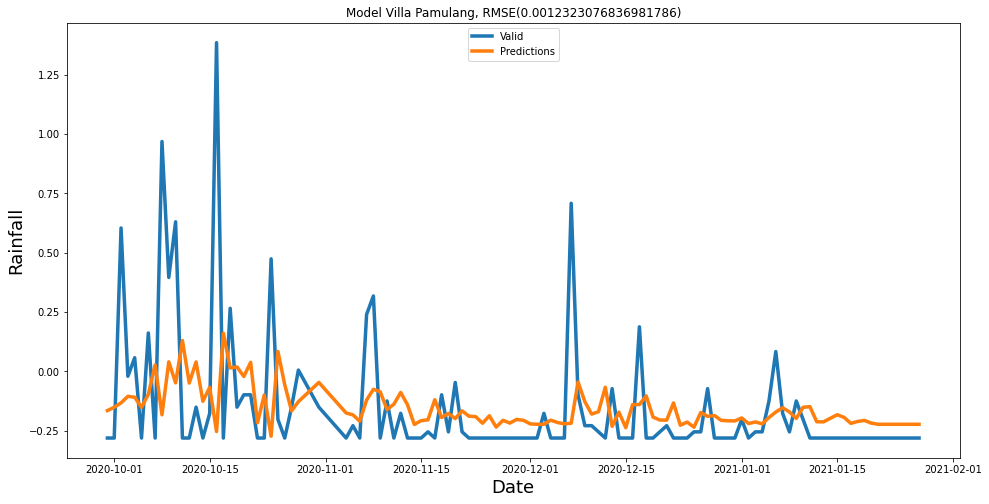

In [34]:
# Generate all regression model for each location
locations = json.load(open(banjir_mapping_location, "r"))["Location"].keys()
window = 10 # can predict 10 days ahead

for location in locations:
  df = get_rainfall_by_location(location)

  # Normalize Rainfall
  df["Rainfall"] = scaler.transform(df["Rainfall"].values.reshape(-1,1)).ravel()

  # Plot data
  # plotting the data
  if ENABLE_OUTPUT: 
    plt.figure(figsize=(16, 8))
    plt.title('Historical Rainfall data from %s'%location)
    plt.plot(df["Date"],df['Rainfall'], color='red')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Rainfall (mm)', fontsize=18)
    plt.show()

  # create new data frame with only 'Rainfall' column
  data = df[['Rainfall']]
  dataset = data.values # convert the data frame to numpy array
  trainning_data_len = np.math.ceil(len(dataset)*.8) # number of rows to train model

  # Create feature using sliding window
  train_data = dataset[0:trainning_data_len, :]

  # Split the data into x_train, y_train datasets
  x_train = []
  y_train = []
  for i in range(window, len(train_data)):
      x_train.append(train_data[i-window:i, 0])
      y_train.append(train_data[i, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)
  clf = LinearRegression(n_jobs=-1, normalize=True)
  clf.fit(x_train, y_train)

  test_data = dataset[trainning_data_len-window:, :]
  # Create the data sets x_test and y_test
  x_test = []
  y_test = dataset[trainning_data_len:, :]
  for i in range(window, len(test_data)):
      x_test.append(test_data[i-window:i, 0])

  # convert the data  to numpy array
  x_test = np.array(x_test)

  forecast_set = clf.predict(x_test)

  # Accuracy (RMSE)
  rmse = np.sqrt(np.mean(forecast_set - y_test)**2)

  # plot the data
  train = data[:trainning_data_len]
  valid = data[trainning_data_len:]
  valid['Predictions'] = forecast_set

  # visualization of the data
  if ENABLE_OUTPUT: 
    plt.figure(figsize=(16,8))
    plt.title('Model %s, RMSE(%s)'%(location, rmse))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Rainfall', fontsize=18)
    # plt.plot(train['Rainfall'], linewidth=3.5)
    plt.plot(df[trainning_data_len:]["Date"], valid[['Rainfall', 'Predictions']],  linewidth=3.5)
    plt.legend(['Valid','Predictions'], loc='upper center')
    plt.show()

  pickle.dump(clf, open("models/mreg-predict-banjir-%s.pkl"%location, "wb"))

# Usage In Cloud

In [35]:
import pandas as pd
import numpy as np
import pickle
import json
from datetime import timedelta

class Transformer:
  """Convert non numeric categorical data to numeric value
  """
  def __init__(self):
    self.mapping_keys = {}
    self.mapping_location = "transformer-map.json"

  def load(self):
    self.mapping_keys = json.load(open(self.mapping_location, "r"))
    return self.mapping_location

  def fit_transform(self, df):
    columns = df.columns.values
    self.mapping_keys = {}

    for column in columns:
      text_digit_vals = {}
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        column_contents = df[column].values.tolist()
        unique_elements = sorted(set(column_contents), key=lambda x: str(x))
        x = 0
        for unique in unique_elements:
          if unique not in text_digit_vals:
            text_digit_vals[unique] = x
            x += 1
        df[column] = df.apply(lambda row: text_digit_vals[row[column]], axis=1)
        self.mapping_keys[column] = text_digit_vals

      return df

  def transform(self, df):
    columns = df.columns.values
    for column in columns:
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        df[column] = df.apply(lambda row: self.mapping_keys[column][row[column]], axis=1)
    return df
  
  def save_mapping(self):
    json.dump(self.mapping_keys, open(self.mapping_location, "w"))
    return self.mapping_location

# Load datasheet
df_tmrain_tmwater_days = pd.read_csv("df_tmrain_tmwater_days.csv")
def get_rainfall_by_location(location, upto_date=None):
  if upto_date:
    return df_tmrain_tmwater_days[["Date", "Location", "Rainfall"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")[df_tmrain_tmwater_days["Date"] <= upto_date]
  return df_tmrain_tmwater_days[["Date", "Location", "Rainfall"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")

# load transfomer
transformer = Transformer()
banjir_mapping_location = transformer.load()

# loads all models to memory for fast response
## classification model
models = {}
mknn_banjir = pickle.load(open("models/mknn-predict-banjir.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))
models["mknn-banjir"] = mknn_banjir

## regression models
locations = json.load(open(banjir_mapping_location, "r"))["Location"].keys()
for location in locations:
  m = pickle.load(open("models/mreg-predict-banjir-%s.pkl"%location, "rb"))
  models[location] = m

In [36]:
window = 10
def predict_banjir(location: str, future_days=1, after_date=None):
  # get future forecast
  if after_date:
    data = get_rainfall_by_location(location, upto_date=after_date)
  else:  
    data = get_rainfall_by_location(location)
  
  # Normalize Data
  data["Rainfall"] = scaler.transform(data["Rainfall"].values.reshape(-1,1)).ravel()
  
  time = data[['Date']]
  data = data[['Rainfall']]
  dataset = data.values # convert the data frame to numpy array
  len_dataset = len(dataset)
  history_data = dataset[len_dataset-2*window:, :] # get last 20 days data

  # predict rainfall next future_days
  rmses = []
  for i in range(future_days):
    # predict rainfall next day
    
    x_test = []
    y_test = history_data

    for i in range(window, len(history_data)):
        x_test.append(history_data[i-window:i, 0])

    # convert the data  to numpy array
    x_test = np.array(x_test)

    forecast_set = models[location].predict(x_test)

    # calculate error
    rmse = np.sqrt(np.mean(forecast_set - y_test)**2)
    rmses.append(rmse)

    # new history based on prediction
    history_data = np.concatenate((history_data, [[forecast_set[-1]]]))
    history_data = np.delete(history_data, 0, axis=0)
  
  # predict banjir or no using knn model
  input_value = []
  for i in range(future_days):
    input_value.append([location, forecast_set[i]])
  # if ENABLE_OUTPUT:  print("input_value (scaled)=",input_value)
  df_banjir_to_predict = pd.DataFrame(input_value, columns=["Location", "Rainfall"])
  df_banjir_to_predict = transformer.transform(df_banjir_to_predict)
  predictions = models['mknn-banjir'].predict(df_banjir_to_predict)

  # prepare output prediction
  # 95% Confidence Interval (CI) example. CI = y_hat +/- 1.96*rmse

  # Inverse transform Rainfall
  forecast_set = scaler.inverse_transform(forecast_set.reshape(-1,1)).ravel()

  output = []
  pred_time = pd.to_datetime(time.values[-1][0])
  for i in range(future_days):
    pred_time =  pred_time + timedelta(days=1)
    output.append([predictions[i], rmses[i], forecast_set[i], pred_time])
  return output, ("prediction", "rmse", "forecasted_rainfall", "date")

output, col_name = predict_banjir("Sumur Batu", future_days=3)
if ENABLE_OUTPUT: pd.DataFrame(output, columns=col_name)

In [37]:
# Kampung Kelapa before 2019-12-24

if ENABLE_OUTPUT: df_tmrain_tmwater_days[df_tmrain_tmwater_days["Location"] == "Kampung Kelapa"].sort_values("Date")[df_tmrain_tmwater_days["Date"] <= "2019-12-24"].tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
output, out_name = predict_banjir("Kampung Kelapa", future_days=10, after_date="2019-12-14")
if ENABLE_OUTPUT: pd.DataFrame(output, columns=out_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
